**Tìm ra phương pháp điền khuyết hiệu quả trên tập dữ liệu giao dịch chứng khoáng**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import isinf
from tqdm import tqdm
from numpy import array, zeros, full, argmin, inf, ndim
import random
import math
from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount('/content/drive')

# **1. Load data**

In [14]:
path = '/content/drive/MyDrive/Học kì 6/Đồ án/DS200/'
data = pd.read_csv(path+'AAPL.csv', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

In [15]:
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sắp xếp dữ liệu theo thời gian tăng dần
data = data.sort_values('Date')

# Chuyển cột 'Date' sang vị trí mới theo index của cột
data = data.set_index('Date')

# Chuyển về kiểu dữ liệu phù hợp
#data['Volume'] = data['Volume'].astype(int)

# **2. Điền khuyết**

Sử dụng 2 phương pháp:
- Linear Interpolation (Nội suy tuyến tính)
- Phương pháp eDTWBI

## **2.1. Function**

In [3]:
def create_missing_(df, number_of_missing, seed): # Số dòng muốn khuyêt
  '''Tạo các đoạn khuyết có kích thước cố định với index ngẫu nhiên'''
  random.seed(a=seed, version=2)
  init_idx = random.randint(0, df.shape[0])
  new_df = df.assign()
  new_df.iloc[init_idx:init_idx + number_of_missing, :] = np.nan
  return new_df

def create_missing(df, percent_missing, seed): #Tỷ lệ phần trăm dữ liệu khuyết muốn tạo
    '''Tạo các đoạn khuyết có kích thước cố định với index ngẫu nhiên'''
    random.seed(a=seed, version=2)
    total_rows = df.shape[0]
    number_of_missing = int(total_rows * percent_missing)
    init_idx = random.randint(0, total_rows - number_of_missing)
    new_df = df.copy()
    new_df.iloc[init_idx:init_idx + number_of_missing, :] = np.nan
    return new_df

def findna(data):
  temp = data.reset_index(drop = True)
  l = temp[temp.isna().any(axis = 1)].index
  return l

def plot_missing_value(p, column, k):
  '''Trực quan hóa đường dữ liệu với khoảng khuyết dựa vào tỷ lệ phần trăm.'''
  x = p.index.values
  y = p[column].values

  plt.figure(figsize = (25, 5))
  plt.plot(x, y ,color = 'seagreen', linewidth = 0.7)
  plt.title(f'Khoảng khuyết {k}%', fontsize = 15)

In [4]:
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        # Lựa chọn hướng di chuyển có giá trị nhỏ nhất trong ma trận D
        tb = argmin((D[i, j], D[i, j + 1], D[i + 1, j]))
        if tb == 0:
            # Di chuyển theo đường chéo
            i -= 1
            j -= 1
        elif tb == 1:
            # Di chuyển lên trên
            i -= 1
        else:  # (tb == 2):
            # Di chuyển sang trái
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

In [5]:
def derivative_dtw_distance(i, j, x, y):
    if i+1 == len(x) or j+1 == len(y):
        dist = (x[i] - y[j])**2

    else:
        d_x_i = ((x[i] - x[i-1]) + (x[i+1] - x[i-1])/2)/2
        d_y_j = ((y[j] - y[j-1]) + (y[j+1] - y[j-1])/2)/2

        dist = (d_x_i - d_y_j)**2
        return dist

In [6]:
def dtw(x, y, dist, warp=1, w=inf, s=1.0):
    '''
    Tính toán Dynamic Time Warping (DTW) của hai chuỗi.
    :param array x: Mảng kích thước N1*M
    :param array y: Mảng kích thước N2*M
    :param func dist: Hàm khoảng cách được sử dụng làm độ đo chi phí
    :param int warp: Số lần dịch chuyển tính toán.
    :param int w: Kích thước cửa sổ giới hạn khoảng cách tối đa giữa các chỉ số của các phần tử được khớp |i,j|.
    :param float s: Trọng số được áp dụng trên các bước chuyển đến ô không nằm trên đường chéo chính. Khi s tăng lên, đường cong uốn lượn được điều chỉnh ngày càng gần đường chéo chính.
    Trả về khoảng cách tối thiểu, ma trận chi phí, ma trận tích lũy chi phí và đường cong uốn lượn.
    '''
    assert len(x)
    assert len(y)
    assert isinf(w) or (w >= abs(len(x) - len(y)))
    assert s > 0
    r, c = len(x), len(y)
    if not isinf(w):
        D0 = full((r + 1, c + 1), inf)
        for i in range(1, r + 1):
            D0[i, max(1, i - w):min(c + 1, i + w + 1)] = 0
        D0[0, 0] = 0
    else:
        D0 = zeros((r + 1, c + 1))
        D0[0, 1:] = inf
        D0[1:, 0] = inf
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            if (isinf(w) or (max(0, i - w) <= j <= min(c, i + w))):
                D1[i, j] = dist(i, j, x, y)
    C = D1.copy()
    jrange = range(c)
    for i in range(r):
        if not isinf(w):
            jrange = range(max(0, i - w), min(c, i + w + 1))
        for j in jrange:
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                i_k = min(i + k, r)
                j_k = min(j + k, c)
                min_list += [D0[i_k, j] * s, D0[i, j_k] * s]
            D1[i, j] += min(min_list)
    if len(x) == 1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1], C, D1, path

In [7]:
def dtwbi(D, Q, len_gap, stride=1):
  ''' Tìm vị trí bắt đầu tốt nhất trong dữ liệu để điền vào khoảng khuyết.'''

  min_dtw_cost = inf
  start_index = 0

  for i in range(0, len(D)-len_gap, stride):
		#print(i, i+len_gap)
    try:
      cost, cost_matrix, acc_cost_matrix, path = dtw(D[i:i+len_gap], Q, dist=derivative_dtw_distance)
    except:
      print(D[i*len_gap:(i+1)*len_gap])
      print('Q', Q)
      print('len_gap', len_gap)
      print('len(D)', len(D))
      print(i*len_gap, (i+1)*len_gap)
      raise
    if cost < min_dtw_cost:
      min_dtw_cost = cost
      start_index=i
  return start_index

In [8]:
def apply_dtwbi_after(x, start_index, end_index, span=16*2): # span = 2 day
	len_gap = end_index - start_index

	Qa = x[end_index:end_index+len_gap]
	Da = x[end_index+len_gap:end_index+len_gap+span]

	Qas_start = dtwbi(Da, Qa, len_gap)
	#Qas = x[Qas_start:Qas_start+len_gap]

	if Qas_start-len_gap < 0:
		refA = x[Qas_start:Qas_start+len_gap] # = Qa
	else:
		refA = x[Qas_start-len_gap:Qas_start] # Previous window of Qas

	return refA

def apply_dtwbi_before(x, start_index, end_index, span=16*2): # span = 2 day
	len_gap = end_index - start_index

	Qb = x[start_index-len_gap:start_index]
	Db = x[start_index-len_gap-span:start_index-len_gap]

	if len(Qb) == 0:
		print('start_index', start_index)
		print('len_gap', len_gap)
		print('end_index', end_index)
		raise

	Qbs_start = dtwbi(Db, Qb, len_gap)
	#Qbs = x[Qbs_start:Qbs_start+len_gap]

	if Qbs_start+2*len_gap > len(x):
		refB = x[Qbs_start:Qbs_start+len_gap] # = Qb

	else:
		refB = x[Qbs_start+len_gap:Qbs_start+2*len_gap] # Next window of Qbs

	return refB

In [9]:
def edtwbi(x, start_index, end_index):
	len_gap = end_index - start_index

	if end_index + len_gap >= len(x):
		refB = apply_dtwbi_before(x, start_index, end_index) # only dtwbi in other direction

		return refB

	elif start_index-len_gap <= 0:
		refA = apply_dtwbi_after(x, start_index, end_index) # only dtwbi in other direction

		return refA

	else: # both cannot simultaneously happen, so not keeping a case for that
		refA = apply_dtwbi_after(x, start_index, end_index)
		refB = apply_dtwbi_before(x, start_index, end_index)

		return np.mean([np.array(refA), np.array(refB)], axis = 0)

In [10]:
def find_gaps(x):
    seq = False
    missing_seqs = []
    seq_start_idx = -1
    for i in range(len(x)):
        if seq == False and x[i] == 0:
            seq = True
            seq_start_idx = i

        elif seq == True and x[i] != 0:
            seq = False
            if seq_start_idx == -1:
                raise
            missing_seqs.append((seq_start_idx, i))
            seq_start_idx = -1

    return missing_seqs

In [11]:
def fill_gaps(df, column_name):
    row = df.fillna(value=0)[column_name].to_list()

    # Sao chép dữ liệu để điền khuyết
    row_filled = row.copy()

    # Tìm khoảng khuyết
    gaps = find_gaps(row)

    # Điền khuyết bằng phương pháp DTW
    for gap in tqdm(gaps, total=len(gaps)):
        if gap[1] - gap[0] < 0.3 * len(row):
            row_filled[gap[0]:gap[1]] = edtwbi(row, gap[0], gap[1])

    # Tạo DataFrame đã điền khuyết
    df_filled = df.copy()
    df_filled[column_name] = row_filled

    return df_filled

In [12]:
def edtwbi_impute(df):
  df = fill_gaps(df, 'Open')
  df = fill_gaps(df, 'Close')
  df = fill_gaps(df, 'High')
  df = fill_gaps(df, 'Low')
  df = fill_gaps(df, 'Volume')
  return df

In [19]:
def Sim(A,B, data):
  A = np.array(A)
  B = np.array(B)
  sim=0
  for i in findna(data):
    s = 1 / (1 + (abs(B[i]-A[i]) / (max(A)-min(A) )))
    sim += s
  sim = sim / len(findna(data))
  return sim

def variance(data, ddof=0):
  n = len(data)
  mean = sum(data) / n
  return sum((x - mean) ** 2 for x in data) / (n - ddof)


def SD(data):
  var = variance(data)
  std_dev = math.sqrt(var)
  return std_dev

def FSD(x, y, data):
  x = x.iloc[findna(data)]
  y = y.iloc[findna(data)]
  return 2 * ( abs(SD(y) - SD(x)) / (SD(y) + SD(x)) )

## **2.2. Tạo khoảng khuyết**

In [16]:
# Tạo khoảng khuyết
p_3 = create_missing(data, 0.03, 10)
p_5 = create_missing(data, 0.05, 20)
p_10 = create_missing(data, 0.1, 30)
p_20 = create_missing(data, 0.2, 40)
p_30 = create_missing(data, 0.3, 50)

# In ra số lượng khuyết
print('Khuyết 3%:')
print(p_3.isna().sum(), '\n')
print('Khuyết 5%:')
print(p_5.isna().sum(), '\n')
print('Khuyết 10%:')
print(p_10.isna().sum(), '\n')
print('Khuyết 20%:')
print(p_20.isna().sum(), '\n')
print('Khuyết 30%:')
print(p_30.isna().sum(), '\n')

Khuyết 3%:
Open      139
High      139
Low       139
Close     139
Volume    139
dtype: int64 

Khuyết 5%:
Open      233
High      233
Low       233
Close     233
Volume    233
dtype: int64 

Khuyết 10%:
Open      466
High      466
Low       466
Close     466
Volume    466
dtype: int64 

Khuyết 20%:
Open      932
High      932
Low       932
Close     932
Volume    932
dtype: int64 

Khuyết 30%:
Open      1399
High      1399
Low       1399
Close     1399
Volume    1399
dtype: int64 



In [17]:
print('Khoảng thời gian missing 3%: ', p_3.index[findna(p_3)][0], '-', p_3.index[findna(p_3)][-1])
print('Khoảng thời gian missing 5%: ', p_5.index[findna(p_5)][0], '-', p_5.index[findna(p_5)][-1])
print('Khoảng thời gian missing 10%: ', p_10.index[findna(p_10)][0], '-', p_10.index[findna(p_10)][-1])
print('Khoảng thời gian missing 20%: ', p_20.index[findna(p_20)][0], '-', p_20.index[findna(p_20)][-1])
print('Khoảng thời gian missing 30%: ', p_30.index[findna(p_30)][0], '-', p_30.index[findna(p_30)][-1])

Khoảng thời gian missing 3%:  2006-01-24 00:00:00 - 2006-08-10 00:00:00
Khoảng thời gian missing 5%:  2009-12-02 00:00:00 - 2010-11-03 00:00:00
Khoảng thời gian missing 10%:  2014-06-03 00:00:00 - 2016-04-07 00:00:00
Khoảng thời gian missing 20%:  2012-06-18 00:00:00 - 2016-03-02 00:00:00
Khoảng thời gian missing 30%:  2013-02-06 00:00:00 - 2018-08-24 00:00:00


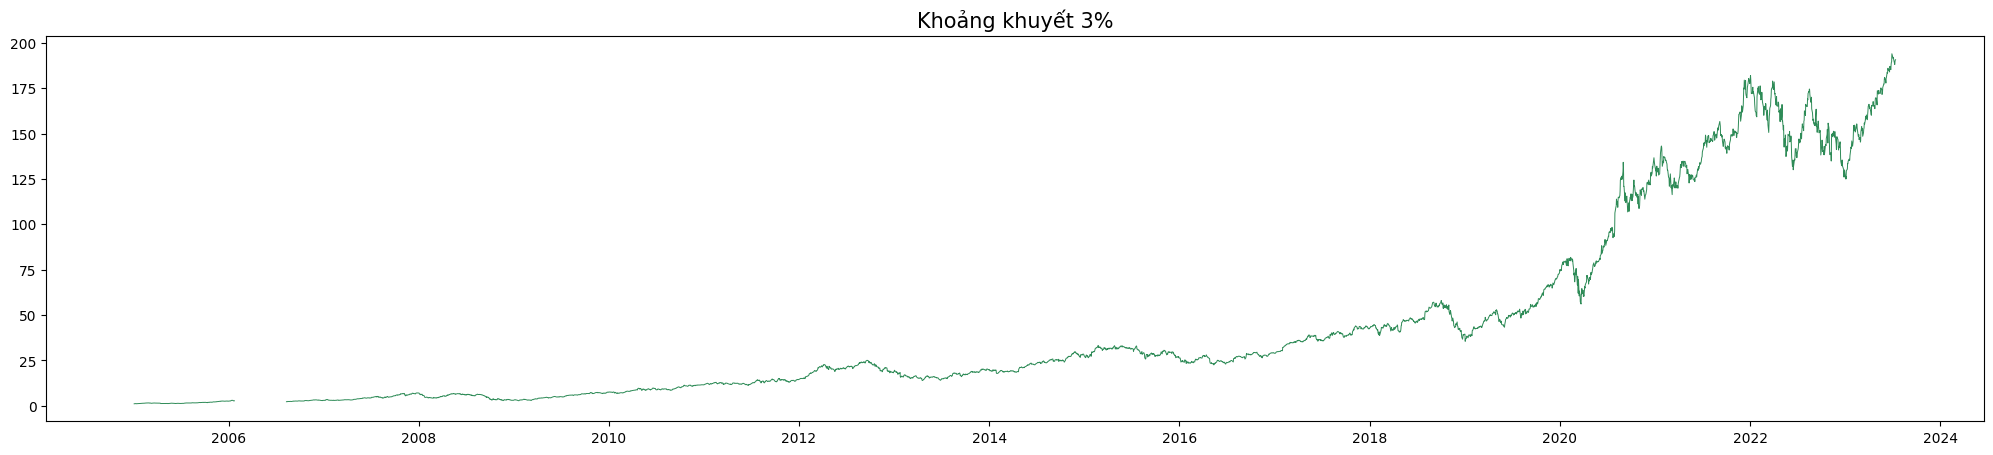

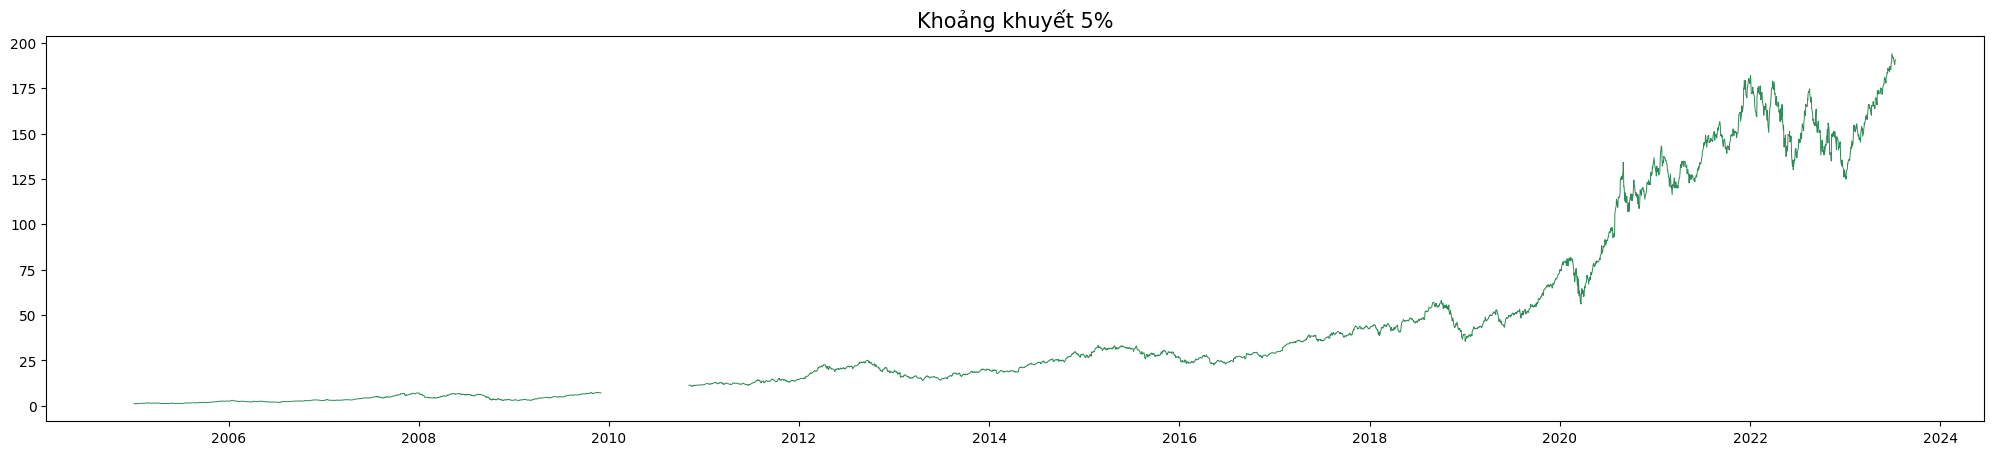

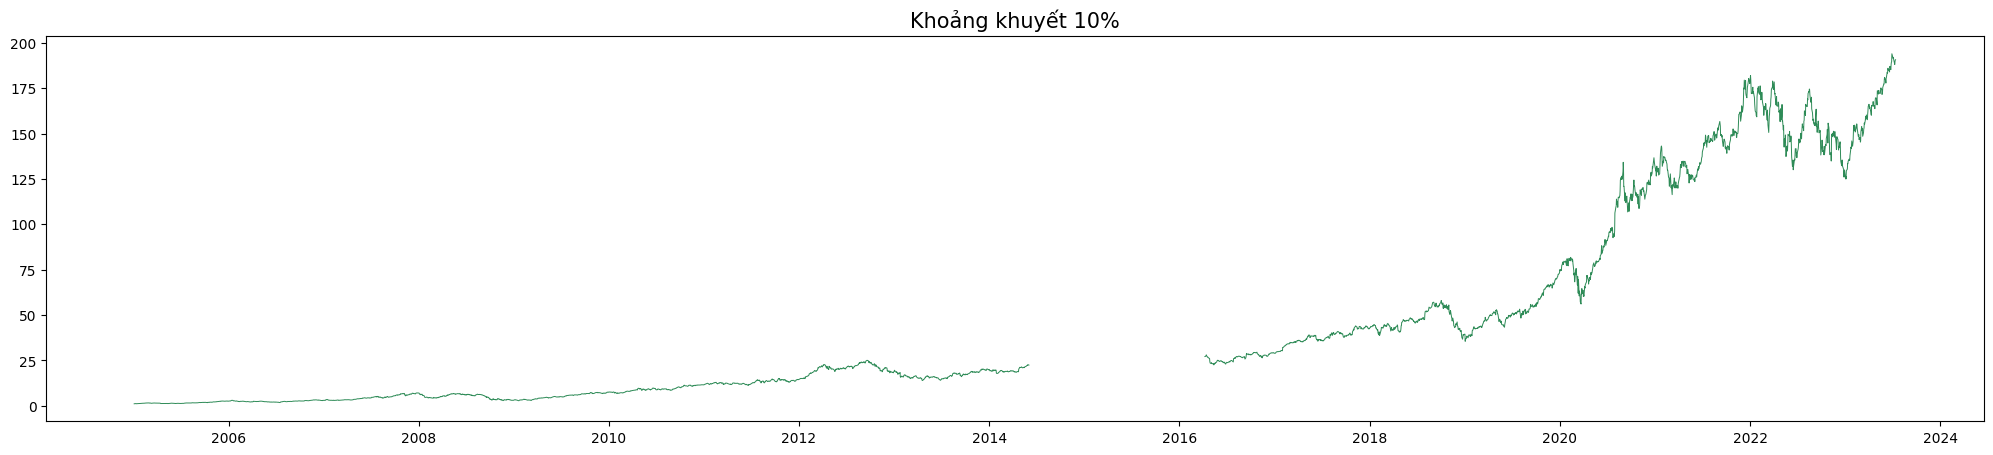

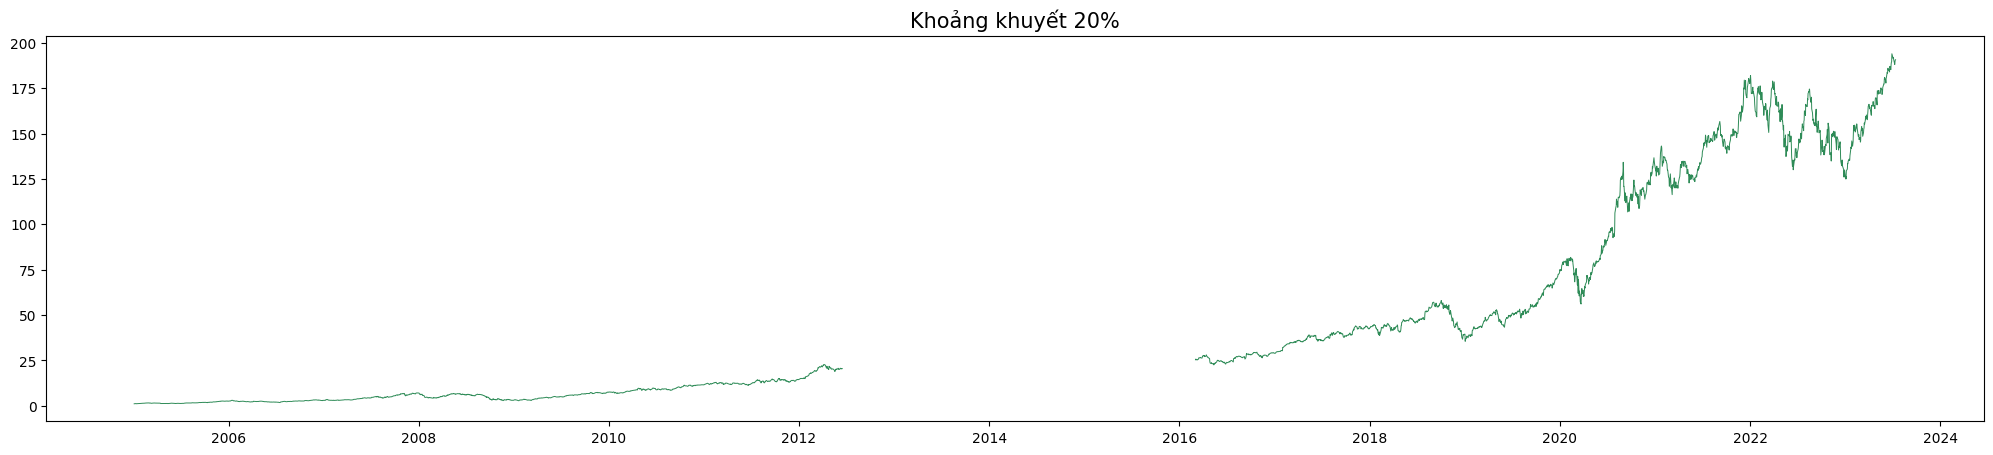

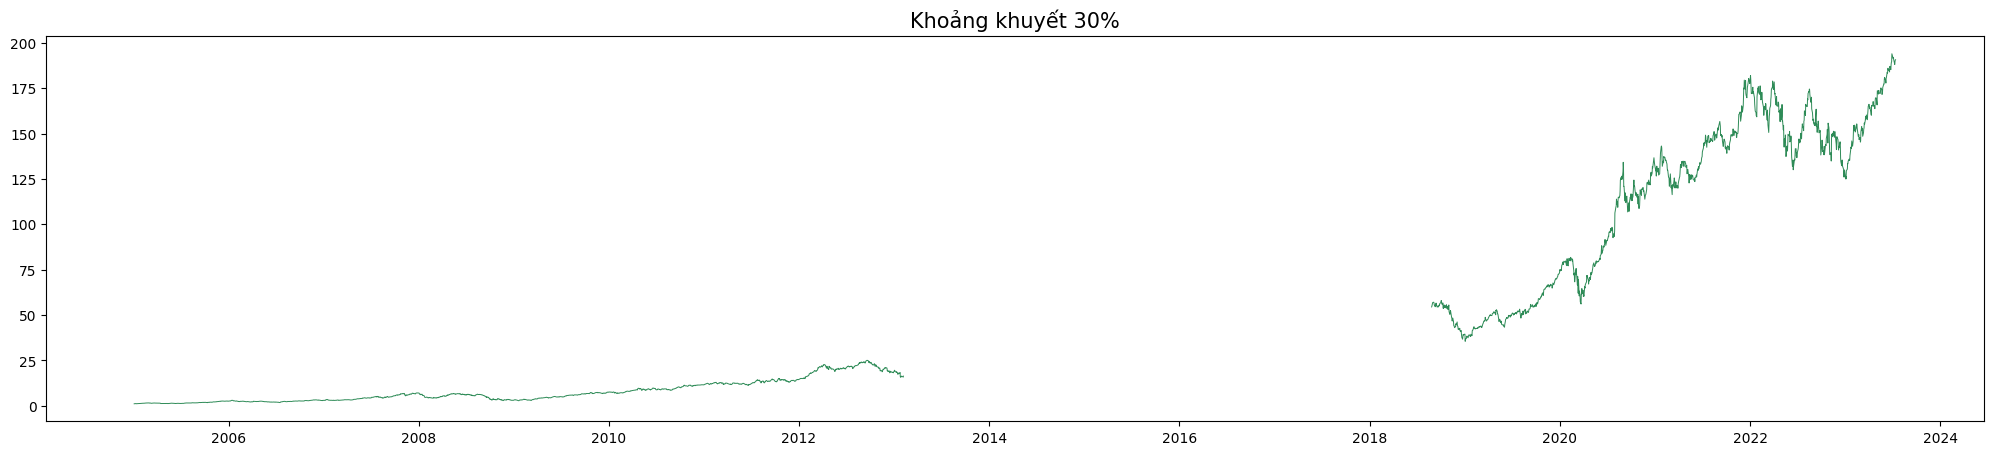

In [18]:
col = 'Close'
plot_missing_value(p_3, col, 3)
plot_missing_value(p_5, col, 5)
plot_missing_value(p_10, col, 10)
plot_missing_value(p_20, col, 20)
plot_missing_value(p_30, col, 30)

## **2.3. Điền khuyết**

In [20]:
# Phương pháp nội suy tuyến tính
df_interpolation_3 = p_3.interpolate(method ='linear', limit_direction ='forward')
df_interpolation_5 = p_5.interpolate(method ='linear', limit_direction ='forward')
df_interpolation_10 = p_10.interpolate(method ='linear', limit_direction ='forward')
df_interpolation_20 = p_20.interpolate(method ='linear', limit_direction ='forward')
df_interpolation_30 = p_30.interpolate(method ='linear', limit_direction ='forward')

In [21]:
# Phương pháp eDTWBI
#https://sti.vista.gov.vn/tw/Lists/TaiLieuKHCN/Attachments/317181/CTv169V19S042021452.pdf
# => Sử dụng eDTWBI

# Phương pháp Median
df_eDTWBI_3 = edtwbi_impute(p_3)
df_eDTWBI_5 = edtwbi_impute(p_5)
df_eDTWBI_10 = edtwbi_impute(p_10)
df_eDTWBI_20 = edtwbi_impute(p_20)
df_eDTWBI_30 = edtwbi_impute(p_30)

100%|██████████| 1/1 [00:00<00:00, 11586.48it/s]


## **2.4. Đánh giá**

In [22]:
col = 'Close'

# Phương pháp Nội suy tuyến tính
print('Điền khuyết bằng Phương pháp Linear Interpolation (Nội suy tuyến tính):')
print('Độ đo Sim')
print('Sim của khuyết 3%: ', Sim(data[col],df_interpolation_3[col], p_3))
print('Sim của khuyết 5%: ', Sim(data[col],df_interpolation_5[col], p_5))
print('Sim của khuyết 10%: ', Sim(data[col],df_interpolation_10[col], p_10))
print('Sim của khuyết 20%: ', Sim(data[col],df_interpolation_20[col], p_20))
print('Sim của khuyết 30%: ', Sim(data[col],df_interpolation_30[col], p_30))
print('Độ đo FSD')
print('FSD của khuyết 3%: ',FSD(data[col],df_interpolation_3[col], p_3))
print('FSD của khuyết 5%: ',FSD(data[col],df_interpolation_5[col], p_5))
print('FSD của khuyết 10%: ',FSD(data[col],df_interpolation_10[col], p_10))
print('FSD của khuyết 20%: ',FSD(data[col],df_interpolation_20[col], p_20))
print('FSD của khuyết 30%: ',FSD(data[col],df_interpolation_30[col], p_30))
print('Độ đo RMSE')
print('RMSE của khuyết 3%: ', mean_squared_error(data[col], df_interpolation_3[col], squared=False))
print('RMSE của khuyết 5%: ', mean_squared_error(data[col], df_interpolation_5[col], squared=False))
print('RMSE của khuyết 10%: ', mean_squared_error(data[col], df_interpolation_10[col], squared=False))
print('RMSE của khuyết 20%: ', mean_squared_error(data[col], df_interpolation_20[col], squared=False))
print('RMSE của khuyết 30%: ', mean_squared_error(data[col], df_interpolation_30[col], squared=False))

# Phương pháp eDTWBI
print('')
print('Điền khuyết bằng Phương pháp eDTWBI:')
print('Độ đo Sim')
print('Sim của khuyết 3%: ', Sim(data[col],df_eDTWBI_3[col], p_3))
print('Sim của khuyết 5%: ', Sim(data[col],df_eDTWBI_5[col], p_5))
print('Sim của khuyết 10%: ', Sim(data[col],df_eDTWBI_10[col], p_10))
print('Sim của khuyết 20%: ', Sim(data[col],df_eDTWBI_20[col], p_20))
print('Sim của khuyết 30%: ', Sim(data[col],df_eDTWBI_30[col], p_30))
print('Độ đo FSD')
print('FSD của khuyết 3%: ',FSD(data[col],df_eDTWBI_3[col], p_3))
print('FSD của khuyết 5%: ',FSD(data[col],df_eDTWBI_5[col], p_5))
print('FSD của khuyết 10%: ',FSD(data[col],df_eDTWBI_10[col], p_10))
print('FSD của khuyết 20%: ',FSD(data[col],df_eDTWBI_20[col], p_20))
print('FSD của khuyết 30%: ',FSD(data[col],df_eDTWBI_30[col], p_30))
print('Độ đo RMSE')
print('RMSE của khuyết 3%: ', mean_squared_error(data[col], df_eDTWBI_3[col], squared=False))
print('RMSE của khuyết 5%: ', mean_squared_error(data[col], df_eDTWBI_5[col], squared=False))
print('RMSE của khuyết 10%: ', mean_squared_error(data[col], df_eDTWBI_10[col], squared=False))
print('RMSE của khuyết 20%: ', mean_squared_error(data[col], df_eDTWBI_20[col], squared=False))
print('RMSE của khuyết 30%: ', mean_squared_error(data[col], df_eDTWBI_30[col], squared=False))

Điền khuyết bằng Phương pháp Linear Interpolation (Nội suy tuyến tính):
Độ đo Sim
Sim của khuyết 3%:  0.9987757630172022
Sim của khuyết 5%:  0.997191477493627
Sim của khuyết 10%:  0.9819771130963957
Sim của khuyết 20%:  0.9806864602964355
Sim của khuyết 30%:  0.9683618745599377
Độ đo FSD
FSD của khuyết 3%:  0.31680118160578774
FSD của khuyết 5%:  0.0734741022612922
FSD của khuyết 10%:  0.7428362787050888
FSD của khuyết 20%:  1.1717611800953251
FSD của khuyết 30%:  0.17417406618608425
Độ đo RMSE
RMSE của khuyết 3%:  0.04678630735789546
RMSE của khuyết 5%:  0.15607703353469865
RMSE của khuyết 10%:  1.3541969884096297
RMSE của khuyết 20%:  1.9876563216619785
RMSE của khuyết 30%:  4.290796146262007

Điền khuyết bằng Phương pháp eDTWBI:
Độ đo Sim
Sim của khuyết 3%:  0.9965175865575875
Sim của khuyết 5%:  0.9663799206837735
Sim của khuyết 10%:  0.8877172516966872
Sim của khuyết 20%:  0.9214954023264087
Sim của khuyết 30%:  0.9020826485571725
Độ đo FSD
FSD của khuyết 3%:  0.5704142498377616
F

In [23]:
col = 'Volume'

# Phương pháp Nội suy tuyến tính
print('Điền khuyết bằng Phương pháp Linear Interpolation (Nội suy tuyến tính):')
print('Độ đo Sim')
print('Sim của khuyết 3%: ', Sim(data[col],df_interpolation_3[col], p_3))
print('Sim của khuyết 5%: ', Sim(data[col],df_interpolation_5[col], p_5))
print('Sim của khuyết 10%: ', Sim(data[col],df_interpolation_10[col], p_10))
print('Sim của khuyết 20%: ', Sim(data[col],df_interpolation_20[col], p_20))
print('Sim của khuyết 30%: ', Sim(data[col],df_interpolation_30[col], p_30))
print('Độ đo FSD')
print('FSD của khuyết 3%: ',FSD(data[col],df_interpolation_3[col], p_3))
print('FSD của khuyết 5%: ',FSD(data[col],df_interpolation_5[col], p_5))
print('FSD của khuyết 10%: ',FSD(data[col],df_interpolation_10[col], p_10))
print('FSD của khuyết 20%: ',FSD(data[col],df_interpolation_20[col], p_20))
print('FSD của khuyết 30%: ',FSD(data[col],df_interpolation_30[col], p_30))
print('Độ đo RMSE')
print('RMSE của khuyết 3%: ', mean_squared_error(data[col], df_interpolation_3[col], squared=False))
print('RMSE của khuyết 5%: ', mean_squared_error(data[col], df_interpolation_5[col], squared=False))
print('RMSE của khuyết 10%: ', mean_squared_error(data[col], df_interpolation_10[col], squared=False))
print('RMSE của khuyết 20%: ', mean_squared_error(data[col], df_interpolation_20[col], squared=False))
print('RMSE của khuyết 30%: ', mean_squared_error(data[col], df_interpolation_30[col], squared=False))

# Phương pháp eDTWBI
print('')
print('Điền khuyết bằng Phương pháp eDTWBI:')
print('Độ đo Sim')
print('Sim của khuyết 3%: ', Sim(data[col],df_eDTWBI_3[col], p_3))
print('Sim của khuyết 5%: ', Sim(data[col],df_eDTWBI_5[col], p_5))
print('Sim của khuyết 10%: ', Sim(data[col],df_eDTWBI_10[col], p_10))
print('Sim của khuyết 20%: ', Sim(data[col],df_eDTWBI_20[col], p_20))
print('Sim của khuyết 30%: ', Sim(data[col],df_eDTWBI_30[col], p_30))
print('Độ đo FSD')
print('FSD của khuyết 3%: ',FSD(data[col],df_eDTWBI_3[col], p_3))
print('FSD của khuyết 5%: ',FSD(data[col],df_eDTWBI_5[col], p_5))
print('FSD của khuyết 10%: ',FSD(data[col],df_eDTWBI_10[col], p_10))
print('FSD của khuyết 20%: ',FSD(data[col],df_eDTWBI_20[col], p_20))
print('FSD của khuyết 30%: ',FSD(data[col],df_eDTWBI_30[col], p_30))
print('Độ đo RMSE')
print('RMSE của khuyết 3%: ', mean_squared_error(data[col], df_eDTWBI_3[col], squared=False))
print('RMSE của khuyết 5%: ', mean_squared_error(data[col], df_eDTWBI_5[col], squared=False))
print('RMSE của khuyết 10%: ', mean_squared_error(data[col], df_eDTWBI_10[col], squared=False))
print('RMSE của khuyết 20%: ', mean_squared_error(data[col], df_eDTWBI_20[col], squared=False))
print('RMSE của khuyết 30%: ', mean_squared_error(data[col], df_eDTWBI_30[col], squared=False))

Điền khuyết bằng Phương pháp Linear Interpolation (Nội suy tuyến tính):
Độ đo Sim
Sim của khuyết 3%:  0.9315196791755074
Sim của khuyết 5%:  0.9490643092653536
Sim của khuyết 10%:  0.9755272007951867
Sim của khuyết 20%:  0.9710493226501353
Sim của khuyết 30%:  0.9605021698306584
Độ đo FSD
FSD của khuyết 3%:  1.2890390241286054
FSD của khuyết 5%:  1.3265958407786878
FSD của khuyết 10%:  0.05951661548347809
FSD của khuyết 20%:  1.0715903862687928
FSD của khuyết 30%:  0.06852653745044555
Độ đo RMSE
RMSE của khuyết 3%:  63647034.231836215
RMSE của khuyết 5%:  60257050.618085966
RMSE của khuyết 10%:  34553816.06845869
RMSE của khuyết 20%:  75588405.84217958
RMSE của khuyết 30%:  89243836.36275479

Điền khuyết bằng Phương pháp eDTWBI:
Độ đo Sim
Sim của khuyết 3%:  0.9020531541103606
Sim của khuyết 5%:  0.915729357082684
Sim của khuyết 10%:  0.8342931389508891
Sim của khuyết 20%:  0.8817331664565567
Sim của khuyết 30%:  0.9471916644119832
Độ đo FSD
FSD của khuyết 3%:  0.20312526612720347
FSD 

- Độ đo Sim: Gần 1 => Gần giống với dữ liệu ban đầu.
- Độ đo FSD: Gần 0 => Độ lệch chuẩn giữa dữ liệu điền khuyết và dữ liệu ban đầu là nhỏ.
- Độ đo RMSE: Các giá trị RMSE thấp => Sai số giữa dữ liệu điền khuyết và dữ liệu ban đầu là nhỏ.

# => ***Kết luận:*** Phương pháp Linear Interpolation (Nội suy tuyến tính) hiệu quả hơn trong bộ dữ liệu này